In [1]:
import pandas as pd
import os
from PIL import Image
from IPython.display import Image

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, display

# <center>STAT 208: Final Project <br><br> By Mason Del Rosario, Anthony Nguyen, Abdul-Hakeem Omotayo </center>
    

<b>Abstract</b>: In this data analysis project, we investigate two machine learning techniques for classifying healthy and infected patients based on X-Ray images. As a baseline, we apply a classic computer vision pipeline, using Histogram of Oriented Gradients (HOG) for feature extraction and Support Vector Machines (SVM) for classification on the extracted HOG features. We compare the SVM classifier with deep convolutional neural networks (CNNs) trained under supervised learning.  We will utilize popular pre-trained image classification residual network, ResNet50. To make training time tractable, we use Google Cloud’s educational credits to access GPUs/TPUs.

We treat infection detection as a binary classification problem, discriminating between healthy and infected patients. We compare the performance of the SVM- and CNN-based classifiers using receiver operating characteristic (ROC) curves, precision recall (PR) curves, and confusion matrices. We use the Chest X-Ray dataset ([Kaggle](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset), [GitHub](https://github.com/mdelrosa/sta208-covid19-xray)) which consists of images from healthy patients ($N=1576$) and pneumonia patients induced by both viral ($N=1555$) and bacterial ($N=2777$) infections. However, the number of COVID-$19$ cases within the dataset is relatively small ($N=58$), and we will need to supplement this dataset with others.

# <center>Data Visualization</center>

<b>Where to get the code for data analysis? </b> 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://github.com/mdelrosa/sta208-covid19-xray

<b>Where to get the images? </b> 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We pull our images from Kaggle: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

<b>What's the size of the Kaggle file? </b>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color='red'>1.2GB</font> 

<b> Directory structure of Kaggle file </b>
<ul>
  <li>Coronahack-Chest-XRay-Dataset </li>
    <ul> <li> Coronahack-Chest-XRay-Dataset </li> <ul> <li> test </li> <li> train </li> </ul> </ul> 
  <li>Chest_xray_Corona_dataset_Summary.csv</li>
  <li>
Chest_xray_Corona_Metadata.csv</li>
</ul>  

<b>Explanation of files:</b> 
<ul> <li> <font color='blue'><i>test</i></font>: x-rays of healthy/infected patients in the testing set </li> <li> <font color='blue'><i>training</i></font>: x-rays of healthy/infected patients in the training set </li> <li> <font color='blue'><i>Chest_xray_Corona_dataset_Summary.csv</i></font>: Summarizes how many healthy / infected patients in x-ray dataset. </li> <li> <font color='blue'><i>Chest_xray_Corona_Metadata.csv</i></font>: List of x-rays with labels (normal / pnemonia), mentions whether x-ray is from testing/training set, and mentions whether x-ray corresponds to patient with viral or bacterial pneumonia (if applicable).  </li> </ul>


<b>Note</b>: Inside the `Chest_xray_Corona_dataset_Summary.csv` below, we observe the x-ray distribution of healthy and infected patients.

## <left> Chest_xray_Corona_dataset_Summary.csv </left>

$$ \begin{matrix} & \text{Label} & 1 & 2 & \text{ Image Count } \\ 0 & \text{ Normal } &  &  & 1576 \\ 1 & \text{ Pneumonia } & \text{ Stress-Smoking } & \text{ ARDS } & 2 \\ 2 & \text{ Pneumonia }  & \text{ Virus } & & 1493 \\ 3 & \text{ Pneumonia }  & \text{ Virus } & \text{ COVID - } 19 & 58 \\ 4 & \text{ Pneumonia }  & \text{ Virus } & \text{ SARS } & 4 \\ 5 & \text{ Pneumonia }  & \text{ bacteria } &  & 2772 \\ 6 & \text{ Pneumonia }  & \text{ bacteria } & \text{ Streptococcus } & 5\end{matrix} $$

$$ \begin{matrix} \textbf{ Dataset Summary } \end{matrix} $$

<UL>
    <LI><b>Total Image Count: </b> 5910
    <LI><b>Training Data: </b> 5286 (89.44%)
<UL>
<LI>Normal Patients: 1342 (22.7%)
<LI>Pneumonia Patients: 3944 (66.73%)
</UL>
    <LI><b>Testing Data</b> 624 (10.56%)
<UL>
<LI>Normal Patients: 234 (3.96%)
<LI>Pneumonia Patients: 390 (6.6 %)
</UL>
</UL>

<font color='red'>Note:</font>    See the next cell for the bar chart on this summary.

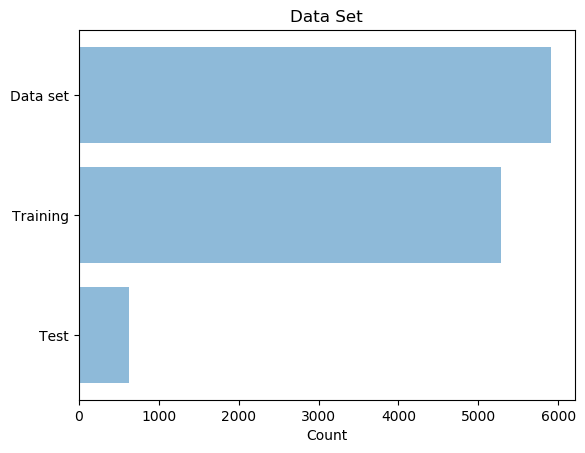

In [3]:
objects = ('Test', 'Training', 'Data set')
y_pos = np.arange(len(objects))
performance = [624,5286,5910]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Count')
plt.title('Data Set')

plt.show()

<b>Note</b>: The next three (<b>3</b>) cells display some rows of the following file: `Chest_xray_Corona_Metadata.csv`

## <left> Chest_xray_Corona_Metadata.csv </left>

In [29]:
filename = "Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [28]:
filename = "Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df[1343:1348]

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
1343,1343,person1019_virus_1708.jpeg,Pnemonia,TRAIN,NaN,Virus
1344,1344,person1019_virus_1707.jpeg,Pnemonia,TRAIN,NaN,Virus
1345,1345,person1019_bacteria_2950.jpeg,Pnemonia,TRAIN,NaN,bacteria
1346,1346,person1018_virus_1706.jpeg,Pnemonia,TRAIN,NaN,Virus
1347,1347,person1018_bacteria_2949.jpeg,Pnemonia,TRAIN,NaN,bacteria


In [25]:
filename = "Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df[5244:5249]

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5244,5255,D7AF463C-2369-492D-908D-BE1911CCD74C.jpeg,Pnemonia,TRAIN,COVID-19,Virus
5245,5256,D5ACAA93-C779-4E22-ADFA-6A220489F840.jpeg,Pnemonia,TRAIN,COVID-19,Virus
5246,5257,9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg,Pnemonia,TRAIN,COVID-19,Virus
5247,5258,93FE0BB1-022D-4F24-9727-987A07975FFB.jpeg,Pnemonia,TRAIN,COVID-19,Virus
5248,5260,8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg,Pnemonia,TRAIN,COVID-19,Virus


<b>Note</b>: In the next cell, we display a sample of $25$ x-rays from health and infected patients taken from `eda.ipynb`. 

## <left> Sample X-rays </left>

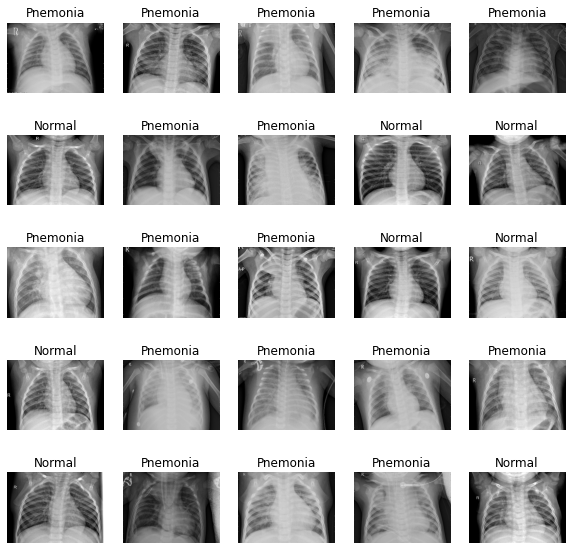

In [17]:
# Display image in current path produced in eda.ipynb
Image("img/sample_xray.png")

## <left> Issues </left>

<ol>
  <li>Some patients have more than one x-ray.</li>
  <li>x-rays have different resolution</li>
    <li> Not every images are grayscale </li>
    <li> Some x-rays don't have label.  </li>
  <li>Small data on COVID-19</li>
    <li> High computation / Large Dataset  </li>
</ol> 

## <left> Discussion of Issues </left>

<font color='red'>Issue #1</font>: 

At first, it was not obvious in discerning whether two x-ray images corresponded to the same patient or not. When we explored the infected patients, this became much clearer in doing so. For instance, <font color='green'>person563_bacteria_2339</font> and <font color='green'>person563_bacteria_2340</font> are filenames of xray images taken from the training set. The prefix <font color='green'>563</font> makes it clear that some patients have multiple x-ray images. 

On the otherhand, for normal patients, it was not straightforward. Most labeled filenames of x-rays from healthy patients contained the string 'NORMAL2' and/or 'IM'; for instance, <font color='green'>'NORMAL2-IM-0600-0001'</font> and <font color='green'>'IM-0614-0001'</font> corresponds to x-ray images from healthy patients. Upon further inspection, we found a way to discern whether a healthy patient had more than one x-ray. For instance, look at four x-ray images: <font color='green'>'IM-0428-0001'</font>,<font color='green'>'IM-0429-0001'</font>, <font color='green'>'IM-0429-0001-0001'</font>, and <font color='green'>'IM-0429-0001-0002'</font>. The x-rays that have twelve (12) digit numbers in the filenames meant patients had multiple x-rays. In this example, the patient that had x-ray <font color='green'>'IM-0428-0001'</font> had only 1 x-ray since there were no x-ray that had the prefix <font color='green'>'IM-0428'</font> and twelve (12) numbers in the filename.

<font color='red'>Issue #2</font>: In the section <font color='blue'>DATA Distribution</font>, we see the distribution of the x-ray images. This provides a challenge to both of our machine learning models SVM (with HOG) and CNN (ResNet). Due to the computation and time limitation, we rescale each image in the following way: For each image, we rescale the largest length of the image to $600$ while preserving the aspect ratio of the image. Finally, we pad the image with zeros so the resulting image is $600 \times 600$.

<font color='red'>Issue #3</font>: From the bar chart in the <font color='blue'>Data Distribution</font> section, we have approximately ~200 RGB x-rays. In our simulations we convert these RGB images using `conversion.py` by averaging the three channels to grayscales. 

<font color='red'>Issue #4</font>: Running <font color='blue'>summarize_images</font> in `eda.ipynb`, we have 23 images that are not in `Chest_xray_Corona_Metadata.csv`. In other words, they have no labels. Therefore, we have to preprocess the data to exclude them; this is done in `conversion.py` using <font color='blue'>list_unique_x_ray</font> function. 

<font color='red'>Issue #5</font>: As we saw, <b>58</b> out of <b>5910</b> x-ray images (<b>0.98%</b>) belong to COVID-19 patients. Given this constraint, doing data analysis on classifying patients as having COVID-19 or not is challenging. We haven't augmented our COVID-$19$ data in our data analysis project, but if we were to do so, we can use our helper function <font color='blue'>convert_image</font> in `conversion.py` to apply different types of transformation (such as horizontal and vertical shearing) to augment our COVID 19 data for covid classifiction. At the moment, we are not convinced such augmentation will help with COVID-$19$ classification. As we will see in the analysis of our classification models, sorting our dataset for uniqueness of x-rays improved our performance, so we're inclined to believe data augmentation for COVID-19 images will probably not help with COVID-19 classification.  

<font color='red'>Issue #6</font>: Our raw dataset is <b>1.2 GB</b>. This brings several challenges in implementing our two classifiers. During training, we need to form our feature vectors (HOG) using our training images. Running the HOG on our local machine presented memory related issue due to the file size, but we were able to run our HOG simulation on a smaller resolution. Then we feed these vectors into our SVM model; note, our training data from HOG is still large (see HOG section for discussion). For ResNet50, the full dataset is too large to fit in GPU memory, and we utilize the `tensorflow.data.Dataset` API to enable caching on host-side.

<b> Note</b>: In the next cell, the two plots show the distribution of the x-ray sizes (number of rows, number of columns) and the number of RGB and grayscale images taken from `eda.ipynb`.

# <center>Data Distribution</center>

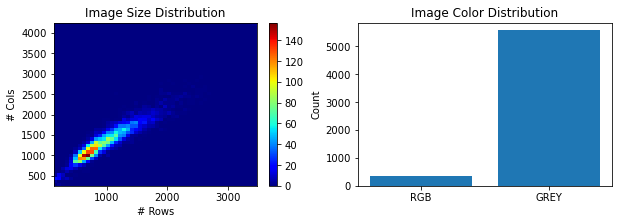

In [12]:
# Display image in current path
Image("img/Image_distribution.png")

# Statistics on Uniqueness

<b>1st Preprocessing on Data</b>: In `conversion.py`, we throw away $93$ x-ray images from Training set; any images that does not contain the string in {'IM','NORMAL2','person'} in its title gets removed (see <i>Data Visualization</i> section, <i>Discussion of Issues</i> subsection, <font color='red'>Issue #1</font>). This step is to preprocess in getting ready to sort for unique x-rays (1 x-ray per patient). 

<font color='blue'><i>Before sorting</i></font> for uniqueness, here is the breakdown of the training and testing set: 

<b>Test</b>: 624 (10.68%) 

<b>Training</b>: 5216 (89.31%)

<font color='blue'><i>After sorting</i></font> for unique x-rays,

<b>Test</b>: 415 (13.32%) 

<b>Training</b>: 2700 (86.67%)

<b>Note</b>: See bar graphs in the next two cells for the distribution of testing and training set before and after sorting for uniqueness. 

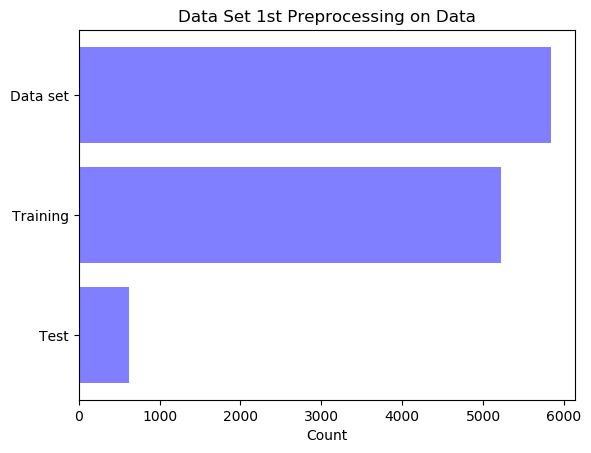

In [46]:
objects = ('Test', 'Training', 'Data set')
y_pos = np.arange(len(objects))
performance = [624,5216,5840]

plt.barh(y_pos, performance, align='center', alpha=0.5,color = 'b')
plt.yticks(y_pos, objects)
plt.xlabel('Count')
plt.title('Data Set 1st Preprocessing on Data')

plt.show()

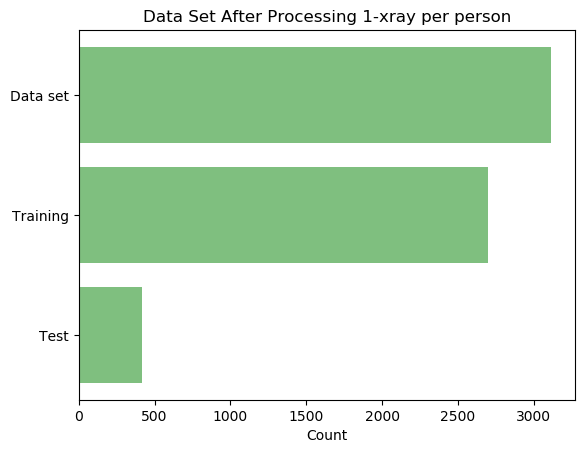

In [47]:
objects = ('Test', 'Training', 'Data set')
y_pos = np.arange(len(objects))
performance = [415,2700,3115]

plt.barh(y_pos, performance, align='center', alpha=0.5, color = 'g')
plt.yticks(y_pos, objects)
plt.xlabel('Count')
plt.title('Data Set After Processing 1-xray per person')

plt.show()

## <left> Data Preprocessing Steps: Summarized </left>

<ul>
    <li> <font color='blue'>Remove filenames</font> (each correspond to an x-ray of a patient) that does not contain 'IM', 'NORMAL2', or 'person' as a substring (done in <font color='red'>conversion.py</font>) </li>
    <li> <font color='blue'>Convert</font> RBG Images to grayscale </li>
    <li> <font color='blue'>Sort</font> dataset for uniqueness (1 x-ray per person) using function <font color='red'>list_unique_x_ray</font> in <font color='red'>conversion.py</font> </li>
    <li> Apply <font color='blue'>image transformation</font> to be processed in our machine learning models (see section on our implemented machine learning models for more detail on transformation used) </li> 
</ul>

# <center>Histogram of Orientated Gradients (HOG) </center> 

# <center> Machine Learning Model #1: Support Vector Machine with HOG feature vectors </center>

<font color='red'>Background:</font> We provide five (<b>5</b>) simulations of SVM with HOG and will link the relevant .ipynb for readers to reference. 

<b>HOG setup</b>: After the preprocessing steps mentioned in the <font color='red'>Data Distribution</font> section, we tune the HOG with the following parameters and preprocessing. We squareroot each pixel of each x-ray. A form $8$ bins which is utilized in forming the gradient orientation histogram using the magnitude of the gradients and angle of the gradients. Each cell consists of $16$ pixels $\times 16$ pixels and each block consists of $2 \times 2$ cells, where we perform $L^1$ normalization over each block. 

<b> SVM Tuning</b>: C value $1$, gamma $=0.1$, kernel = polynomial. This setting proved to perform the best out of the following hyperparameters being tuned in the next line. 

<font color='red'>SVM Hyperparameter Tuning</font>: We used the following parameters: $C \in \{0.1,1,10\}$, gamma $ = \{0.01,0.1,1\}$, kernel $ = $ polynomial, linear, radial basis function.

<font color='blue'>Simulation #1:</font> We rescale each image in the following manner. Rescale the image while preserving the aspect ratio such that the largest dimension (length or width) is $600$ pixels. Then zero pad the image such that it is $600 \times 600$ 

<font color='blue'>Simulation #2:</font> Same as simulation #1 and perform a horizontal flip on each image.

<font color='blue'>Simulation #3:</font> Same as simulation #1 except largest dimension is $300$ pixels. Add Gaussian noise from mean $\mu = 50$, standard deviation $\sigma = 1$ to image. Zero pad the image to $300$ pixels $\times 300$ pixels.

<font color='blue'>Simulation #4:</font> Note: This simulation has not been sorted for uniqueness and is using the whole testing set. Resize each image to $300$ pixels by $300$ pixels. Note this doesn't preserve aspect ratio. 

<font color='blue'>Simulation #5:</font> Same as simulation #1. Then rotate each images by $10^{\circ}$ counterclockwise. 

# <left> Discussion on Support Vector Machine with HOG: simulation </left>

<font color='red'>Note</font>: See `HOG-sim1.ipynb`, `HOG-sim2.ipynb`,`HOG-sim3.ipynb`,`HOG-sim4.ipynb`,`HOG-sim5.ipynb` for code and images generated from code.

# <left> SVM HOG Simulation #1 </left>

In [2]:
display(HTML("<table><tr><td><img src='img/sim1_roc.png'></td><td><img src='img/sim1_pr.png'></td></tr><tr><td><img src='img/sim1_conf.png'></td><tr><td><img src='img/sim1_xray_test.png'></td></table>"))

<b>Figure 1</b>: ROC curve, PR curve, Confusion matrix, Gradient fields of x-ray, x-ray

# <left> SVM HOG Simulation #2 </left>

In [4]:
display(HTML("<table><tr><td><img src='img/sim2_roc.png'></td><td><img src='img/sim2_pr.png'></td></tr><tr><td><img src='img/sim2_conf.png'></td><tr><td><img src='img/sim2_xray_test.png'></td></table>"))

<b>Figure 2</b>: ROC curve, PR curve, Confusion matrix, Gradient fields of x-ray, x-ray

# <left> SVM HOG Simulation #3 </left>

In [5]:
display(HTML("<table><tr><td><img src='img/sim3_roc.png'></td><td><img src='img/sim3_pr.png'></td></tr><tr><td><img src='img/sim3_conf.png'></td><tr><td><img src='img/sim3_xray_test.png'></td></table>"))

<b>Figure 3</b>: ROC curve, PR curve, Confusion matrix, Gradient fields of x-ray, x-ray

# <left> SVM HOG Simulation #4 </left>

In [8]:
display(HTML("<table><tr><td><img src='img/sim4_roc.png'></td><td><img src='img/sim4_pr.png'></td></tr><tr><td><img src='img/sim4_conf.png'></td><tr><td><img src='img/sim4_xray_test.png'></td></table>"))

<b>Figure 4</b>: ROC curve, PR curve, Confusion matrix, Gradient fields of x-ray, x-ray

# <left> SVM HOG Simulation #5 </left>

In [10]:
display(HTML("<table><tr><td><img src='img/sim5_roc.png'></td><td><img src='img/sim5_pr.png'></td></tr><tr><td><img src='img/sim5_conf.png'></td><tr><td><img src='img/sim5_xray_test.png'></td></table>"))

<b>Figure 5</b>: ROC curve, PR curve, Confusion matrix, Gradient fields of x-ray, x-ray

# <left> SVM HOG Discussion of the five (5) simulations </left>

Among the five simulations, simulation #3 performs the best in classifying healthy patients. Surprisingly, adding gaussian noise improved the healthy classification. On the other hand, we see that simulation #4 performs not too well in contrast to the other simulation; this is not surprising given that we rescale the images to $300 \times 300$ without preserving the aspect ratio. One thing to note is that rescaling images and preserving the aspect ratio improved healthy patient classification as evidenced in simulation #1,#2,#3,#5. 

Every simulation except #4 had similar area under the curve $~0.85$ and $~0.84$ for ROC and PR curves, respectively. However, simulation #4 had area under the curve of $0.93$ and $0.95$ for ROC and PR curves, respectively. 

We ran simulation #2 and #5 out of curiousity to see how sensitive our results are to orthogonal transformations (reflection and rotation). It appears not much, and this attributes to the symmetry in the x-ray images along the y-axis and a small degree rotation of the image won't affect the gradients when constructing the HOG feature vectors. 

# <center>Convolutional Neural Network </center>

# <left> Machine Learning Model #2: Residual Neural Network: ResNet50 </left>

## Unique Images vs. All Images

For training, we restrict our attention to unique images (see `train-resnet.ipynb` for details).

For testing, we evaluate on the entire test set -- i.e., there are multiple X-rays from the same patient (see `test-resnet.ipynb` for details).

## Image Sizes

For ResNet50, we performed tests using two different image sizes (Height, Width):

- One-quarter mean: (243, 332)
- One-half mean: (486, 664)

where 'mean' is the average image height and width from all images (972 and 1328 pixels, respectively). Chose this rescaling since it approximately preserves each image's aspect ratio.

## Hyperparameters

We train ResNet50 using `cateogrical_crossentropy` loss with the following hyperparameters:
- Adam with default parameters (`lr=1e-3`)
- `batch_size=16`
- `epochs=100`

## Classification Metrics

We report the classification metrics using the weights from 4 different checkpoints: 10, 25, 50, and 100 epochs.

<font color='red'>Note</font>: See `summarize-resnet.ipynb` for further discussion and for the code which generated the classification metrics plots.

## One-quarter mean

Observations:
- `100 epochs` has the highest `auc` for both PR and ROC.
    - However, looking at the confusion matrix, we see that this model has poor `precision` -- there are 150 false positives and 380 true positives.

### PR Curves

![PR Curves for one-quarter mean](img/quarter/pr-all.png) 

### ROC Curves

![ROC Curves for one-quarter mean](img/quarter/roc-all.png) 

### Confusion Matrices

![Confusion matrices for one-quarter mean](img/quarter/conf-all.png) 

## One-half mean

Observations:
- `10 epochs` has the highest `auc` for both PR and ROC.
    - However, looking at the confusion matrix, we see that this model has poor `recall` -- there are 160 false negatives and 290 true positives.

### PR Curves

![PR Curves for one-half mean](img/half/pr-all.png) 

### ROC Curves

![ROC Curves for one-half mean](img/half/roc-all.png) 

### Confusion Matrices

![Confusion matrices for one-half mean](img/half/conf-all.png) 

# <center>Conclusion</center>

<b>A.</b> We compare the $300 \times 300$ image resolution from HOG/SVM (simulation #3 and #4) to the one-quarter mean for ResNet50 since the images share similar image resolution. 

<b>B.</b> Similarly, we compare simulation #1,2,5 (which are $600 \times 600$ image resolution) to the one-half mean.

<b>Discussion A:</b> It seems that with both the PR and ROC curves, both methods on average do as well. If we ignore simulation #4 (doesn't take into account of aspect ratio), we see that ResNet50 performs better on the auc, but simulation #3 lower number of missclassification of health patients when we comparare it with 100 epochs. 

<b>Discussion B:</b> We see that the SVM/HOG does better than ResNet50. One metric is examine the auc between these two methods. We observe with small number of epochs, SVM/HOG and ResNet50 seem comparable in respect to auc, but the confusion matrix for 10, 25 epochs show that there is a high number of infected patients classified as healthy (something the SVM/HOG doesn't do) and the other shows a large number of misclassification of health patients.  


# <center>Future Directions</center>

<ol>
    <li> K-fold cross validation. </li>
  <li>Patients with multiple x-ray images: Averaging scheme.</li>
   <li> Spatial Pyramid Pooling layer for ResNet50 </li>
  
    
</ol> 

# <center>Discussion of Future Directions</center>

<font color='red'>Direction #1</font>: This data analysis project proved to be challenging with the challenges the dataset presented us. But if we had sufficient time to explore data munging further, we would write a python script that would modify the file `Chest_xray_Corona_metadata.csv` where we can pool all x-ray images of healthy patients (whether from train / test) and same with x-ray images of infected patients. From there, we can label $1342$ healthy patients at random for instance belonging to the training set ($234$ testing set) and label $3944$ infected patients at random for instance belonging to the training set ($390$ testing set); numbers were chosen from Dataset summary. However, we can do $80%$ healthy/infected patients go to training and the remaining $20%$ go to testing. 

<font color='red'>Direction #2</font>: Recall that our x-ray images have different resolution (see <font color='blue'>Image Size Distribution</font> graph in <font color='blue'>Data Distribution</font> section). One approach we used is randomly select an x-ray if a patient had multiple x-rays and include that in our training and/or testing set. At least for the SVM with HOG, we sorted our training and testing data this way. As for the ResNet50, we train on unique x-rays, but we test on the full testing set.

A future direction for the SVM with HOG is the following. Resize the images as done in simulation #1 of SVM with HOG. For patients with multiple x-rays, we pass each through the HOG and take the convex combination of these HOG feature vectors.

<font color='red'>Direction #3</font>: Since existing deep CNNs require fixed-sized input, this can hurt our classifier's performance when we resize images, which can alter aspect ratio and destroy some pixels. We can introduce a layer called <font color='blue'>spatial pyramid pooling</font> before the fully connected layer. This would be a future direction that we can try given the extra time. From our knowledge, we do not believe there's a simple built in function to add a spatial pyramid layer in our ResNet50 model, we didn't pursue this avenue since it requires understanding what the SPP layer is doing and pulling SPP code from a GitHub repo and add that in (Remark: I have to admit that I have tried pulling a code from the GitHub repo: https://github.com/yhenon/keras-spp and gave it an honest attempt to try to build a CNN and using an SPP layer but was getting an error; the SPP code was complex, so debugging became time consuming). 
